# TP5 - Autoencoders and Variational Autoencoder (VAE)

This notebook explores the use of autoencoders and variational autoencoders (VAEs) for learning compact representations of binary character images.

We work with 7×5 pixel representations of 32 uppercase letters and special characters. The goal is to:
- Encode and reconstruct characters using a simple autoencoder.
- Train a denoising autoencoder to recover clean characters from noisy inputs.
- Build a variational autoencoder (VAE) to generate new character images from a continuous latent space.

The models are implemented using PyTorch, and all characters are visualized to interpret how information is represented and transformed through the network.


### Task 1a


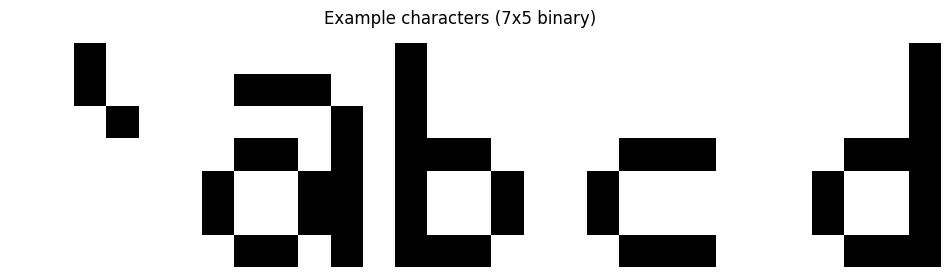

In [1]:
# Preparation: Convert and visualize font data

import numpy as np
import matplotlib.pyplot as plt

# Hex-encoded 7x5 binary characters from font.h
font_data_hex = [
    [0x04, 0x04, 0x02, 0x00, 0x00, 0x00, 0x00],
    [0x00, 0x0e, 0x01, 0x0d, 0x13, 0x13, 0x0d],
    [0x10, 0x10, 0x10, 0x1c, 0x12, 0x12, 0x1c],
    [0x00, 0x00, 0x00, 0x0e, 0x10, 0x10, 0x0e],
    [0x01, 0x01, 0x01, 0x07, 0x09, 0x09, 0x07],
    [0x00, 0x00, 0x0e, 0x11, 0x1f, 0x10, 0x0f],
    [0x06, 0x09, 0x08, 0x1c, 0x08, 0x08, 0x08],
    [0x0e, 0x11, 0x13, 0x0d, 0x01, 0x01, 0x0e],
    [0x10, 0x10, 0x10, 0x16, 0x19, 0x11, 0x11],
    [0x00, 0x04, 0x00, 0x0c, 0x04, 0x04, 0x0e],
    [0x02, 0x00, 0x06, 0x02, 0x02, 0x12, 0x0c],
    [0x10, 0x10, 0x12, 0x14, 0x18, 0x14, 0x12],
    [0x0c, 0x04, 0x04, 0x04, 0x04, 0x04, 0x04],
    [0x00, 0x00, 0x0a, 0x15, 0x15, 0x11, 0x11],
    [0x00, 0x00, 0x16, 0x19, 0x11, 0x11, 0x11],
    [0x00, 0x00, 0x0e, 0x11, 0x11, 0x11, 0x0e],
    [0x00, 0x1c, 0x12, 0x12, 0x1c, 0x10, 0x10],
    [0x00, 0x07, 0x09, 0x09, 0x07, 0x01, 0x01],
    [0x00, 0x00, 0x16, 0x19, 0x10, 0x10, 0x10],
    [0x00, 0x00, 0x0f, 0x10, 0x0e, 0x01, 0x1e],
    [0x08, 0x08, 0x1c, 0x08, 0x08, 0x09, 0x06],
    [0x00, 0x00, 0x11, 0x11, 0x11, 0x13, 0x0d],
    [0x00, 0x00, 0x11, 0x11, 0x11, 0x0a, 0x04],
    [0x00, 0x00, 0x11, 0x11, 0x15, 0x15, 0x0a],
    [0x00, 0x00, 0x11, 0x0a, 0x04, 0x0a, 0x11],
    [0x00, 0x11, 0x11, 0x0f, 0x01, 0x11, 0x0e],
    [0x00, 0x00, 0x1f, 0x02, 0x04, 0x08, 0x1f],
    [0x06, 0x08, 0x08, 0x10, 0x08, 0x08, 0x06],
    [0x04, 0x04, 0x04, 0x00, 0x04, 0x04, 0x04],
    [0x0c, 0x02, 0x02, 0x01, 0x02, 0x02, 0x0c],
    [0x08, 0x15, 0x02, 0x00, 0x00, 0x00, 0x00],
    [0x1f, 0x1f, 0x1f, 0x1f, 0x1f, 0x1f, 0x1f],
]

# Convert to 35-length binary vectors (7 rows × 5 columns = 35)
font_data = []
for char in font_data_hex:
    for row in char:
        font_data.append([int(b) for b in f'{row:05b}'])
font_array = np.array(font_data).reshape(32, 35)

# Visualize first 5 characters
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    axes[i].imshow(font_array[i].reshape(7, 5), cmap='Greys')
    axes[i].axis('off')
plt.suptitle("Example characters (7x5 binary)")
plt.show()

In [69]:
# Train a basic autoencoder with a 2D latent space

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convert font data to PyTorch tensor
X_tensor = torch.tensor(font_array, dtype=torch.float32)
dataset = TensorDataset(X_tensor, X_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(35, 16),
            nn.ReLU(),
            nn.Linear(16, 2)  # 2D latent space
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 35),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

model = Autoencoder()
criterion = nn.BCELoss()  # binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Train the model
for epoch in range(500):
    for batch_X, _ in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_X)
        loss.backward()
        optimizer.step()
#camilla del
# Evaluate reconstruction accuracy after training the autoencoder
with torch.no_grad():
    reconstructions = model(X_tensor).numpy()
    originals = X_tensor.numpy()

# Convert outputs to binary (threshold at 0.5)
recon_bin = (reconstructions > 0.5).astype(int)
orig_bin = (originals > 0.5).astype(int)

# Count the number of incorrect pixels for each character
pixel_errors = np.sum(recon_bin != orig_bin, axis=1)

# Print detailed error report
print("Reconstruction error per character (number of incorrect pixels):")
for i, err in enumerate(pixel_errors):
    print(f"Character {i:02d}: {err} pixel errors")

# Summary statistics
max_error = np.max(pixel_errors)
avg_error = np.mean(pixel_errors)
print(f"\nMaximum pixel error: {max_error}")
print(f"Average pixel error: {avg_error:.2f}")

Reconstruction error per character (number of incorrect pixels):
Character 00: 5 pixel errors
Character 01: 2 pixel errors
Character 02: 8 pixel errors
Character 03: 5 pixel errors
Character 04: 12 pixel errors
Character 05: 6 pixel errors
Character 06: 8 pixel errors
Character 07: 7 pixel errors
Character 08: 7 pixel errors
Character 09: 7 pixel errors
Character 10: 7 pixel errors
Character 11: 9 pixel errors
Character 12: 4 pixel errors
Character 13: 5 pixel errors
Character 14: 2 pixel errors
Character 15: 4 pixel errors
Character 16: 9 pixel errors
Character 17: 10 pixel errors
Character 18: 5 pixel errors
Character 19: 3 pixel errors
Character 20: 7 pixel errors
Character 21: 6 pixel errors
Character 22: 6 pixel errors
Character 23: 8 pixel errors
Character 24: 9 pixel errors
Character 25: 14 pixel errors
Character 26: 7 pixel errors
Character 27: 7 pixel errors
Character 28: 3 pixel errors
Character 29: 9 pixel errors
Character 30: 6 pixel errors
Character 31: 0 pixel errors

Max

In [ ]:
# Train an improved autoencoder with a 2D latent space
# camilla added

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convert font data to PyTorch tensor
X_tensor = torch.tensor(font_array, dtype=torch.float32)
dataset = TensorDataset(X_tensor, X_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Improved autoencoder with deeper layers
class DeepAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(35, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # 2D latent space
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 35),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

# Initialize model, loss function, and optimizer
model = DeepAutoencoder()
criterion = nn.BCELoss()  # binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # lower learning rate

# Train the model for more epochs
for epoch in range(850):
    for batch_X, _ in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_X)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluate reconstruction accuracy after training
with torch.no_grad():
    reconstructions = model(X_tensor).numpy()
    originals = X_tensor.numpy()

# Convert outputs to binary (threshold at 0.5)
recon_bin = (reconstructions > 0.5).astype(int)
orig_bin = (originals > 0.5).astype(int)

# Count the number of incorrect pixels for each character
pixel_errors = np.sum(recon_bin != orig_bin, axis=1)

# Print detailed error report
print("Reconstruction error per character (number of incorrect pixels):")
for i, err in enumerate(pixel_errors):
    print(f"Character {i:02d}: {err} pixel errors")

# Summary statistics
max_error = np.max(pixel_errors)
avg_error = np.mean(pixel_errors)
print(f"\nMaximum pixel error: {max_error}")
print(f"Average pixel error: {avg_error:.2f}")


Epoch 0, Loss: 0.6810
Epoch 100, Loss: 0.2041
Epoch 200, Loss: 0.1561
Epoch 300, Loss: 0.1034
Epoch 400, Loss: 0.0806
Epoch 500, Loss: 0.0475
Epoch 600, Loss: 0.0048
Epoch 700, Loss: 0.0090
Epoch 800, Loss: 0.0049
Reconstruction error per character (number of incorrect pixels):
Character 00: 0 pixel errors
Character 01: 0 pixel errors
Character 02: 0 pixel errors
Character 03: 0 pixel errors
Character 04: 0 pixel errors
Character 05: 0 pixel errors
Character 06: 0 pixel errors
Character 07: 0 pixel errors
Character 08: 0 pixel errors
Character 09: 0 pixel errors
Character 10: 0 pixel errors
Character 11: 0 pixel errors
Character 12: 0 pixel errors
Character 13: 0 pixel errors
Character 14: 0 pixel errors
Character 15: 0 pixel errors
Character 16: 0 pixel errors
Character 17: 0 pixel errors
Character 18: 0 pixel errors
Character 19: 0 pixel errors
Character 20: 0 pixel errors
Character 21: 0 pixel errors
Character 22: 0 pixel errors
Character 23: 0 pixel errors
Character 24: 0 pixel err

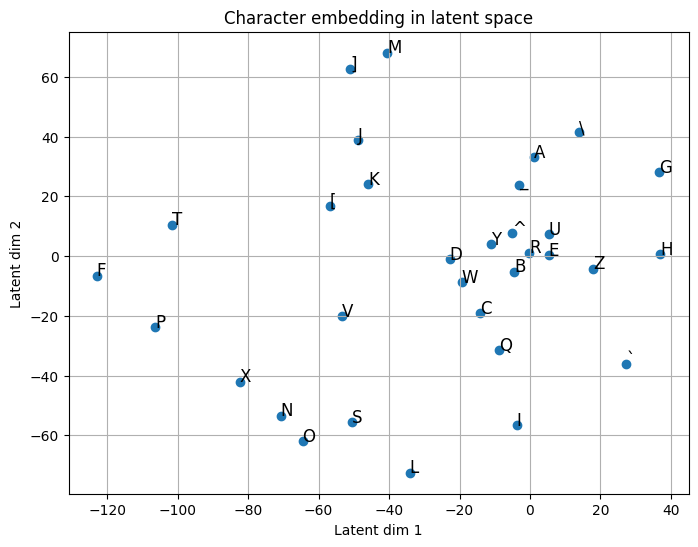

In [80]:
# Visualize latent space: how each character is encoded in the 2D latent space

with torch.no_grad():
    latent_coords = model.encoder(X_tensor).numpy()

plt.figure(figsize=(8, 6))
plt.scatter(latent_coords[:, 0], latent_coords[:, 1])
for i, (x, y) in enumerate(latent_coords):
    plt.text(x, y, chr(65 + i), fontsize=12)  # A-Z and a few symbols
plt.xlabel("Latent dim 1")
plt.ylabel("Latent dim 2")
plt.title("Character embedding in latent space")
plt.grid(True)
plt.show()


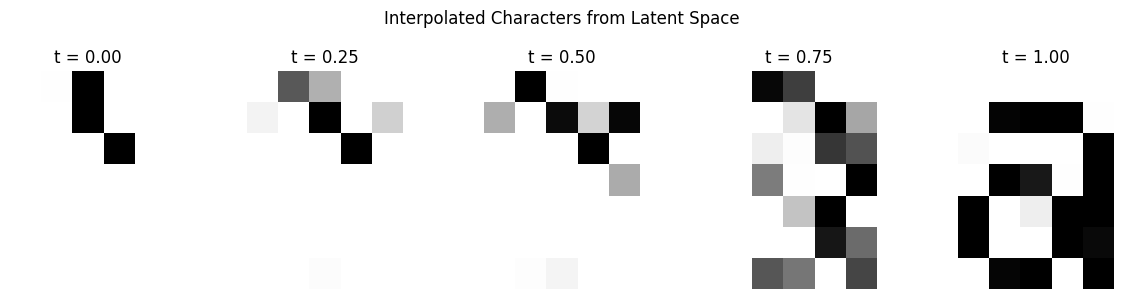

In [ ]:
# camilla
#4. Show how the network can generate a new character not part of the training set.

# Interpolate between two characters in the latent space
with torch.no_grad():
    z_start = model.encoder(X_tensor[0])  # e.g. character 0
    z_end = model.encoder(X_tensor[1])    # e.g. character 1
    interpolations = [(1 - t) * z_start + t * z_end for t in torch.linspace(0, 1, steps=5)]
    decoded = [model.decoder(z).numpy().reshape(7, 5) for z in interpolations]

# Plot the generated characters
fig, axs = plt.subplots(1, 5, figsize=(12, 3))
for i, img in enumerate(decoded):
    axs[i].imshow(img, cmap='binary')
    axs[i].axis('off')
    axs[i].set_title(f"t = {i/4:.2f}")
plt.suptitle("Interpolated Characters from Latent Space")
plt.tight_layout()
plt.show()


### Task 1.b

In [82]:
# Add noise to input characters
noise_level = 0.3
X_noisy = X_tensor + noise_level * torch.rand_like(X_tensor)
X_noisy = torch.clamp(X_noisy, 0., 1.)  # Keep values between 0 and 1

# Define and train new autoencoder on noisy input
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(35, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 35),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

denoiser = DenoisingAutoencoder()
criterion = nn.BCELoss()
optimizer = optim.Adam(denoiser.parameters(), lr=0.005)

# Train the denoising autoencoder
noisy_dataset = TensorDataset(X_noisy, X_tensor)
noisy_loader = DataLoader(noisy_dataset, batch_size=8, shuffle=True)

for epoch in range(120):
    for batch_X_noisy, batch_X_clean in noisy_loader:
        optimizer.zero_grad()
        outputs = denoiser(batch_X_noisy)
        loss = criterion(outputs, batch_X_clean)
        loss.backward()
        optimizer.step()

In [ ]:
# camilla
# with the new autoconder
# Add noise to input characters
noise_level = 0.3  # Reduced for better results
X_noisy = X_tensor + noise_level * torch.rand_like(X_tensor)
X_noisy = torch.clamp(X_noisy, 0., 1.)  # Keep values between 0 and 1

# Define and train new autoencoder on noisy input
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(35, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 35),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

denoiser = DenoisingAutoencoder()
criterion = nn.BCELoss()
optimizer = optim.Adam(denoiser.parameters(), lr=0.005)

# Train the denoising autoencoder
noisy_dataset = TensorDataset(X_noisy, X_tensor)
noisy_loader = DataLoader(noisy_dataset, batch_size=8, shuffle=True)

for epoch in range(300):  # Increased training duration
    for batch_X_noisy, batch_X_clean in noisy_loader:
        optimizer.zero_grad()
        outputs = denoiser(batch_X_noisy)
        loss = criterion(outputs, batch_X_clean)
        loss.backward()
        optimizer.step()


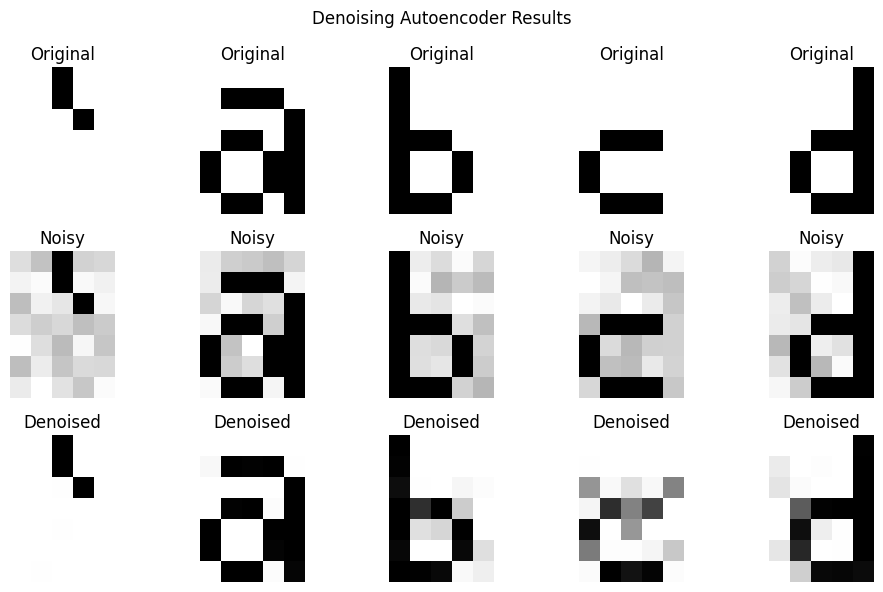

In [84]:
# Visualize denoising results

# Predict cleaned characters from noisy input
with torch.no_grad():
    cleaned = denoiser(X_noisy).numpy()

# Show comparison
fig, axs = plt.subplots(3, 5, figsize=(10, 6))
for i in range(5):
    axs[0, i].imshow(X_tensor[i].reshape(7, 5), cmap='binary')
    axs[0, i].set_title("Original")
    axs[1, i].imshow(X_noisy[i].reshape(7, 5), cmap='binary')
    axs[1, i].set_title("Noisy")
    axs[2, i].imshow(cleaned[i].reshape(7, 5), cmap='binary')
    axs[2, i].set_title("Denoised")
    for row in axs[:, i]:
        row.axis('off')
plt.suptitle("Denoising Autoencoder Results")
plt.tight_layout()
plt.show()

### Emoji-generation
Goal: Evaluate generalization of Autoencoder on custom patterns



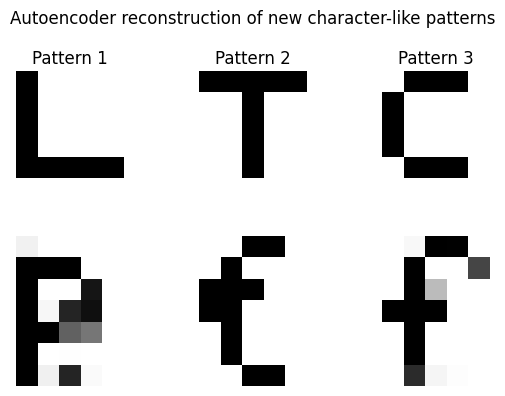

In [85]:
# Evaluate generalization of Autoencoder on new simple 7x5 patterns

# Define simple 7x5 binary patterns inspired by character-like shapes
custom_patterns = torch.tensor([
    # "L"-shape
    [
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]
    ],
    # "T"-shape
    [
        [1, 1, 1, 1, 1],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]
    ],
    # "C"-like shape
    [
        [0, 1, 1, 1, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]
    ]
], dtype=torch.float32).reshape(-1, 35)

# Pass through trained Autoencoder
with torch.no_grad():
    recon_custom = model(custom_patterns)

# Visualize original vs reconstructed patterns
fig, axs = plt.subplots(2, len(custom_patterns), figsize=(len(custom_patterns)*2, 4))
for i in range(len(custom_patterns)):
    axs[0, i].imshow(custom_patterns[i].reshape(7, 5), cmap='binary')
    axs[1, i].imshow(recon_custom[i].reshape(7, 5), cmap='binary')
    axs[0, i].set_title(f"Pattern {i+1}")
    axs[0, i].axis('off')
    axs[1, i].axis('off')
axs[0, 0].set_ylabel("Original")
axs[1, 0].set_ylabel("Reconstructed")
plt.suptitle("Autoencoder reconstruction of new character-like patterns")
plt.tight_layout()
plt.show()


# Task 2

### Task 2a: VAE

In [86]:
# Define Variational Autoencoder with encoder, reparameterization, decoder

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(35, 16),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(16, 2)
        self.fc_logvar = nn.Linear(16, 2)

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 35),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=0.01)

# Loss function: reconstruction loss + KL divergence

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# Training loop
for epoch in range(300):
    for batch_X, _ in dataloader:
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(batch_X)
        loss = vae_loss(recon_batch, batch_X, mu, logvar)
        loss.backward()
        optimizer.step()

### Task 2b 

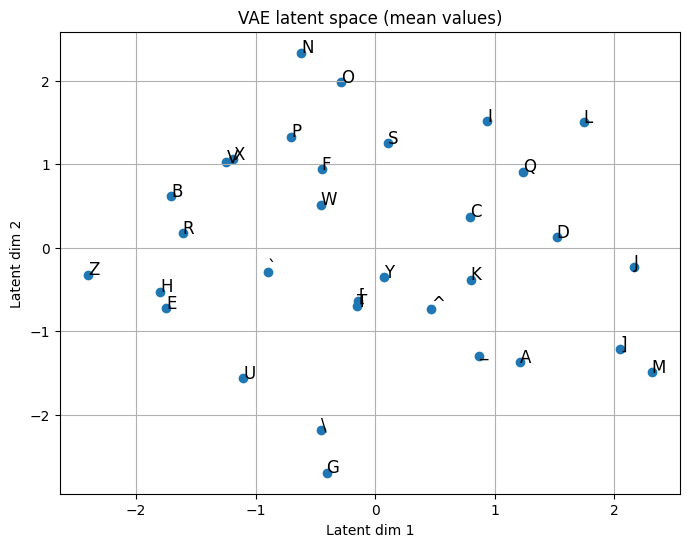

In [87]:
# Plot latent space representation of input characters

with torch.no_grad():
    mu_vals, _ = vae.encode(X_tensor)
    mu_vals = mu_vals.numpy()

plt.figure(figsize=(8, 6))
plt.scatter(mu_vals[:, 0], mu_vals[:, 1])
for i, (x, y) in enumerate(mu_vals):
    plt.text(x, y, chr(65 + i), fontsize=12)
plt.xlabel("Latent dim 1")
plt.ylabel("Latent dim 2")
plt.title("VAE latent space (mean values)")
plt.grid(True)
plt.show()


### Task 2c

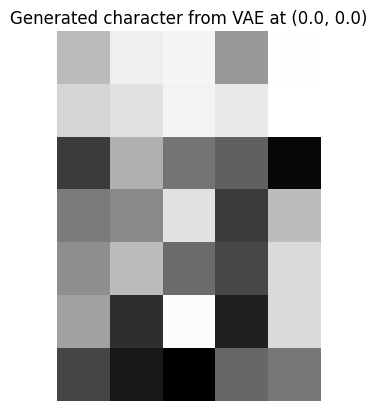

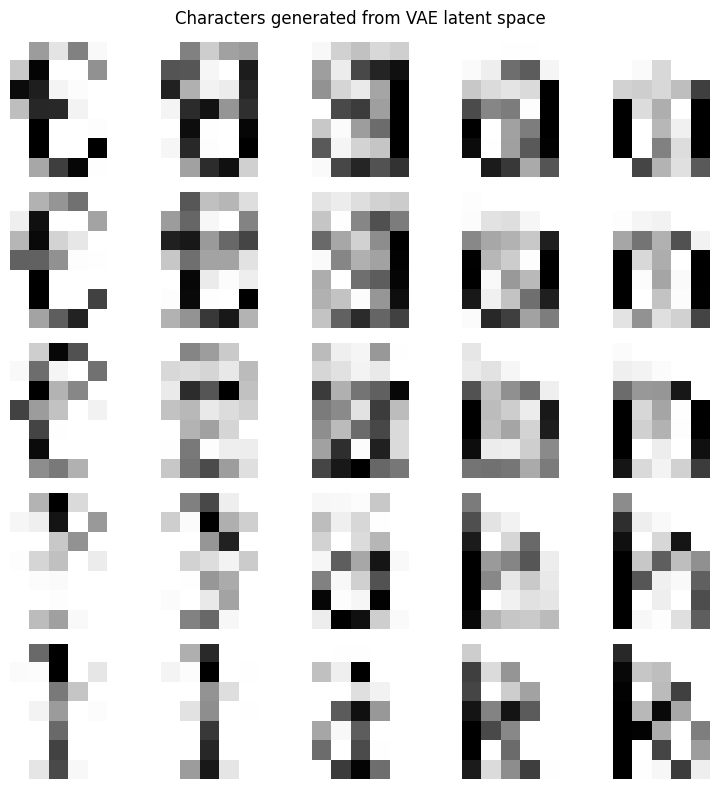

In [88]:
# Sample and generate characters from VAE latent space
# Generate a new character from a sample point in latent space

sample_point = torch.tensor([[0.0, 0.0]], dtype=torch.float32)

with torch.no_grad():
    generated = vae.decoder(sample_point).numpy().reshape(7, 5)

plt.imshow(generated, cmap='binary')
plt.title("Generated character from VAE at (0.0, 0.0)")
plt.axis('off')
plt.show()

# Sample multiple points in a grid and visualize

n = 5  # Grid size
range_vals = np.linspace(-2, 2, n)

fig, axes = plt.subplots(n, n, figsize=(8, 8))
for i, x in enumerate(range_vals):
    for j, y in enumerate(range_vals):
        z = torch.tensor([[x, y]], dtype=torch.float32)
        with torch.no_grad():
            sample = vae.decoder(z).numpy().reshape(7, 5)
        axes[i, j].imshow(sample, cmap='binary')
        axes[i, j].axis('off')
plt.suptitle("Characters generated from VAE latent space")
plt.tight_layout()
plt.show()

### Evaluation: Did the model learn all the patterns? 

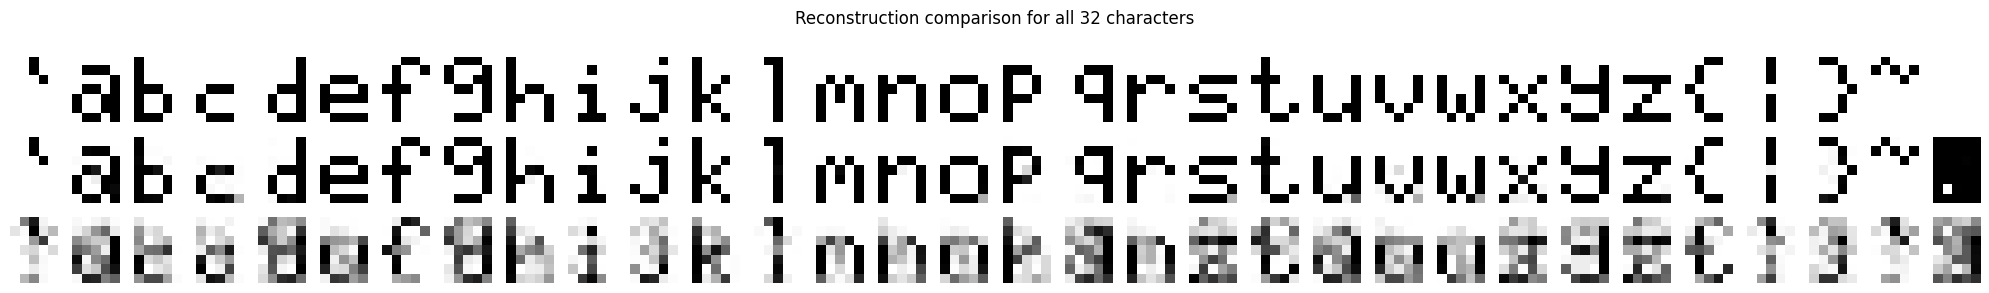

In [89]:
# Compare original vs. reconstructed characters (Autoencoder vs. VAE)

with torch.no_grad():
    ae_recon = model(X_tensor).numpy()
    vae_recon, _, _ = vae(X_tensor)
    vae_recon = vae_recon.numpy()

fig, axs = plt.subplots(3, 32, figsize=(20, 3))
for i in range(32):
    axs[0, i].imshow(X_tensor[i].reshape(7, 5), cmap='binary')
    axs[1, i].imshow(ae_recon[i].reshape(7, 5), cmap='binary')
    axs[2, i].imshow(vae_recon[i].reshape(7, 5), cmap='binary')
    for j in range(3):
        axs[j, i].axis('off')
axs[0, 0].set_ylabel("Original")
axs[1, 0].set_ylabel("Autoencoder")
axs[2, 0].set_ylabel("VAE")
plt.suptitle("Reconstruction comparison for all 32 characters")
plt.tight_layout()
plt.show()

### Evaluation Summary

The reconstruction results show that the autoencoder and VAE models successfully capture the majority of patterns in the binary character set.

- The **Autoencoder** tends to preserve sharpness and fine structure more reliably.
- The **VAE** can occasionally blur or distort certain letters, especially those with similar patterns.

Overall, the models demonstrate a strong ability to learn and represent the 7x5 binary character patterns.
```


### Conclusion

In this notebook, we implemented and explored different types of autoencoders for binary character reconstruction:

- A **basic autoencoder** was trained to compress and reconstruct 7×5 characters using a 2D latent space.
- A **denoising autoencoder** demonstrated robustness by recovering clean inputs from noisy versions.
- A **variational autoencoder (VAE)** provided a generative model capable of sampling new characters from its latent space.

Through these experiments, we observed how low-dimensional embeddings capture structural patterns in the data and enable both reconstruction and generative capabilities. The VAE, in particular, allowed for smooth latent space interpolation and character generation, highlighting its strength as a probabilistic model.
